# Using PauliPropagation.jl from Python via JuliaCall

This notebook demonstrates how to leverage the functionalities of the Julia package `PauliPropagation.jl` directly within a Python environment. We achieve this using the `juliacall` library, which acts as a bridge between Python and Julia.

**Goals:**
*   Show how to install and set up `juliacall`.
*   Replicate the "Basic Example" from `PauliPropagation.jl` using Python.
*   Illustrate data type conversions and calling Julia functions.
*   Provide examples of more advanced usage, such as parameter sweeps and visualizations.


### 1. Installation of `juliacall`

This cell provides the command to install the `juliacall` package using `pip`. `juliacall` is essential for enabling Python to interact with Julia. If you haven't installed it yet, uncomment the line and run the cell.

In [ ]:
# Install juliacall if you haven't already
# Uncomment the following line to install
# !pip install juliacall

### 2. Initializing Julia and `PauliPropagation.jl`

This cell performs the following crucial setup steps:
1.  **Imports `juliacall`**: It imports the `Main` object from `juliacall` and aliases it as `jl`. This `jl` object will be our primary interface to Julia.
2.  **Prints Julia Version**: It accesses and prints the version of the underlying Julia interpreter that `juliacall` is using.
3.  **Installs `PauliPropagation.jl`**: It uses `jl.seval()` to execute a Julia code block. This block checks if `PauliPropagation.jl` is already part of the current Julia project's dependencies. If not, it adds the package directly from its GitHub repository. This ensures the package is available for use.
4.  **Imports `PauliPropagation.jl` in Julia**: Finally, it executes `using PauliPropagation` within the Julia environment, making all exported functions and types from the package available through `jl.PauliPropagation`.

In [ ]:
from juliacall import Main as jl

print("Julia version:", jl.VERSION)

# Install PauliPropagation if not already installed
# Note: This might take a while the first time
jl.seval("""
    using Pkg
    if !haskey(Pkg.project().dependencies, "PauliPropagation")
        Pkg.add(url="https://github.com/MSRudolph/PauliPropagation.jl")
    end
""")

jl.seval("using PauliPropagation")

[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliacall/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliapkg/juliapkg.json
[juliapkg] Locating Julia 1.6.1 - 1.10.0, ^1.10.3
[juliapkg] Using Julia 1.10.9 at /usr/local/bin/julia
[juliapkg] Using Julia project at /root/.julia/environments/pyjuliapkg
[juliapkg] Writing Project.toml:
             [deps]
             PythonCall = "6099a3de-0909-46bc-b1f4-468b9a2dfc0d"
             OpenSSL_jll = "458c3c95-2e84-50aa-8efc-19380b2a3a95"
             [compat]
             PythonCall = "=0.9.25"
             OpenSSL_jll = "~3.0"
[juliapkg] Installing packages:
             import Pkg
             Pkg.Registry.update()
             Pkg.add([
               Pkg.PackageSpec(name="PythonCall", uuid="6099a3de-0909-46bc-b1f4-468b9a2dfc0d"),
               Pkg.PackageSpec(name="OpenSSL_jll", uuid="458c3c95-2e84-50aa-8efc-19380b2a3a95"),
             ])
             Pkg.resolve()
          

     Cloning git-repo `https://github.com/MSRudolph/PauliPropagation.jl`
    Updating git-repo `https://github.com/MSRudolph/PauliPropagation.jl`
   Resolving package versions...
   Installed BitIntegers ─ v0.3.5
   Installed Bits ──────── v0.2.0
    Updating `~/.julia/environments/pyjuliapkg/Project.toml`
  [293282d5] + PauliPropagation v0.4.1 `https://github.com/MSRudolph/PauliPropagation.jl#main`
    Updating `~/.julia/environments/pyjuliapkg/Manifest.toml`
  [66dad0bd] + AliasTables v1.1.3
  [c3b6d118] + BitIntegers v0.3.5
  [1654ce90] + Bits v0.2.0
  [34da2185] + Compat v4.16.0
  [864edb3b] + DataStructures v0.18.22
  [ffbed154] + DocStringExtensions v0.9.4
  [92d709cd] + IrrationalConstants v0.2.4
  [2ab3a3ac] + LogExpFunctions v0.3.29
  [e1d29d7a] + Missings v1.2.0
  [293282d5] + PauliPropagation v0.4.1 `https://github.com/MSRudolph/PauliPropagation.jl#main`
  [43287f4e] + PtrArrays v1.3.0
  [a2af1166] + SortingAlgorithms v1.2.1
  [82ae8749] + StatsAPI v1.7.0
  [2913bbd2] + Stat

### 3. Basic Example: Propagating a Pauli Observable

This cell replicates the core "Basic Example" from the `PauliPropagation.jl` documentation, demonstrating the fundamental workflow:

1.  **Define System Size (`nqubits`)**: Sets the number of qubits in the quantum system.
2.  **Create Observable**: Defines a `PauliString` observable using `jl.PauliPropagation.PauliString`. Here, it's a Z operator on qubit 16 in a 32-qubit system. `jl.Symbol("Z")` is used to pass the Pauli operator type as a Julia Symbol.
3.  **Define Circuit Topology**: Creates a `bricklayertopology` for the quantum circuit, which specifies how gates are arranged.
4.  **Create Quantum Circuit**: Defines a Transverse Field Ising Model (TFIM) Trotter circuit using `jl.PauliPropagation.tfitrottercircuit`.
5.  **Set Circuit Parameters**:
    *   `dt`: Defines a time step for the Trotter evolution.
    *   `parameters`: Creates a Julia array filled with the `dt` value, matching the number of parameters required by the circuit. `jl.fill()` is used here to correctly create a Julia array suitable for the `propagate` function.
6.  **Propagate Observable**: Evolves the `observable` through the `circuit` with the given `parameters` using `jl.PauliPropagation.propagate`. It also specifies truncation parameters (`max_weight` and `min_abs_coeff`) to manage the complexity of the resulting `PauliSum`.
7.  **Calculate Overlap**: Computes the expectation value of the propagated `PauliSum` with respect to the all-zeros state (`|0⟩⊗n`) using `jl.PauliPropagation.overlapwithzero`.
8.  **Print Results**: Outputs the initial observable, topology type, number of circuit parameters, number of terms in the resulting `PauliSum`, and the final overlap.

In [ ]:
nqubits = 32

observable = jl.PauliPropagation.PauliString(nqubits, jl.Symbol("Z"), 16)
print("Observable:", observable)

topology = jl.PauliPropagation.bricklayertopology(nqubits, periodic=True)
print("Topology type:", type(topology))

nlayers = 32
circuit = jl.PauliPropagation.tfitrottercircuit(nqubits, nlayers, topology=topology)
print(f"Circuit has {jl.PauliPropagation.countparameters(circuit)} parameters")

dt = 0.1
parameters = jl.fill(dt, jl.PauliPropagation.countparameters(circuit))

max_weight = 6
min_abs_coeff = 1e-4
pauli_sum = jl.PauliPropagation.propagate(
    circuit, observable, parameters,
    max_weight=max_weight, min_abs_coeff=min_abs_coeff
)
print(f"Result has {jl.length(pauli_sum)} Pauli terms")

overlap = jl.PauliPropagation.overlapwithzero(pauli_sum)
print(f"Overlap with |0⟩⊗n: {overlap}")

Observable: PauliString(nqubits: 32, 1.0 * IIIIIIIIIIIIIIIZIIII...)
Topology type: <class 'juliacall.VectorValue'>
Circuit has 2048 parameters
Result has 1671 Pauli terms
Overlap with |0⟩⊗n: 0.15459672824142454


### 4. Visualizing the Observable's Evolution

This cell demonstrates how to visualize the evolution of the observable's expectation value over a range of time steps (`dt`).

1.  **Import Libraries**: Imports `matplotlib.pyplot` for plotting and `numpy` for numerical operations, particularly for creating an array of `dt` values.
2.  **Define Time Points (`dt_values`)**: Creates a `numpy` array of time step values using `np.linspace` to scan.
3.  **Iterate and Propagate**:
    *   It loops through each `dt_val` in `dt_values`.
    *   Inside the loop, it re-calculates the `parameters` array using `jl.fill(dt_val, ...)`.
    *   It calls `jl.PauliPropagation.propagate` for each `dt_val`.
    *   It calculates the `overlapwithzero`.
    *   The resulting overlap (converted to a Python `float`) is appended to the `results` list.
4.  **Plot Results**:
    *   Uses `matplotlib` to create a plot of the expectation value (overlap) against the time step (`dt_values`).
    *   Adds labels, a title, and a grid for better readability.
    *   `plt.show()` displays the plot.

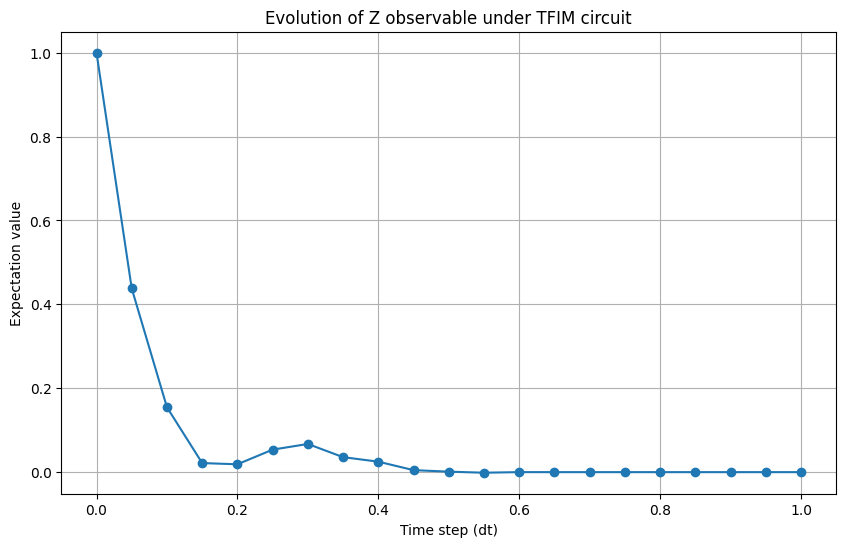

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

dt_values = np.linspace(0.0, 1.0, 21)

results = []

for dt in dt_values:
    parameters = jl.ones(jl.PauliPropagation.countparameters(circuit)) * dt
    pauli_sum = jl.PauliPropagation.propagate(
        circuit, observable, parameters,
        max_weight=max_weight, min_abs_coeff=min_abs_coeff
    )
    overlap = jl.PauliPropagation.overlapwithzero(pauli_sum)
    results.append(float(overlap))

plt.figure(figsize=(10, 6))
plt.plot(dt_values, results, 'o-')
plt.xlabel('Time step (dt)')
plt.ylabel('Expectation value')
plt.title('Evolution of Z observable under TFIM circuit')
plt.grid(True)
plt.show()

### 5. Working with Julia Data Types and Functions from Python

This cell showcases several ways to interact with Julia's data types and functionalities from Python:

1.  **Convert Julia Array to Python NumPy Array**:
    *   `jl.rand(10)`: Creates a Julia array of 10 random numbers.
    *   `np.array(julia_array)`: Converts this Julia array into a Python NumPy array.
    *   The types of both arrays are printed to demonstrate the conversion.
2.  **Define and Call a Custom Julia Function**:
    *   `jl.seval("""...""")`: Defines a new Julia function named `count_nonzero_terms` directly within the Julia runtime. This function takes a `pauli_sum` (expected to be a `PauliSum` object) and returns the number of terms in it using `length(pauli_sum)`.
    *   `jl.count_nonzero_terms(pauli_sum)`: Calls this newly defined Julia function from Python, passing the `pauli_sum` object obtained from the previous propagation.
    *   The result is converted to a Python `int` and printed.
3.  **Access Julia Documentation**:
    *   `jl.seval("@doc PauliPropagation.propagate")`: Executes Julia's macro `@doc` to retrieve the documentation string for the `PauliPropagation.propagate` function.
    *   The fetched documentation text is printed.

In [ ]:
julia_array = jl.rand(10)
python_array = np.array(julia_array)
print("Julia array type:", type(julia_array))
print("Python array type:", type(python_array))

jl.seval("""
function count_nonzero_terms(pauli_sum)
    return length(pauli_sum)
end
""")

num_terms = jl.count_nonzero_terms(pauli_sum)
print(f"Number of non-zero Pauli terms: {int(num_terms)}")

help_text = jl.seval("@doc PauliPropagation.propagate")
print("Documentation for propagate function:")
print(help_text)

Julia array type: <class 'juliacall.VectorValue'>
Python array type: <class 'numpy.ndarray'>
Number of non-zero Pauli terms: 0
Documentation for propagate function:
```
propagate(circ, pstr::PauliString, thetas=nothing; max_weight=Inf, min_abs_coeff=1e-10, max_freq=Inf, max_sins=Inf, customtruncfunc=nothing, kwargs...)
```

Propagate a `PauliString` through the circuit `circ` in the Heisenberg picture.  This means that the circuit is applied to the Pauli string in reverse order, and the action of each gate is its conjugate action. Parameters for the parametrized gates in `circ` are given by `thetas`, and need to be passed as if the circuit was applied as written in the Schrödinger picture. If thetas are not passed, the circuit must contain only non-parametrized `StaticGates`. Default truncations are `max_weight`, `min_abs_coeff`, `max_freq`, and `max_sins`. `max_freq`, and `max_sins` will lead to automatic conversion if the coefficients are not already wrapped in suitable `PathProperti

### 6. Advanced Example: Comparing Different Truncation Settings

This cell extends the visualization by comparing the observable's evolution under different `max_weight` truncation settings.

1.  **Define Settings**:
    *   `weight_settings`: A list of different `max_weight` values to test.
    *   `colors`: A list of colors for plotting, corresponding to each `max_weight`.
2.  **Outer Loop (Iterate `max_weight`)**:
    *   The code iterates through each `max_w` in `weight_settings`.
3.  **Inner Loop (Iterate `dt_values`)**:
    *   For each `max_w`, it iterates through the `dt_values` (time steps) similar to Cell 4.
    *   `parameters` are created using `jl.fill(dt_val, ...)`.
    *   `jl.PauliPropagation.propagate` is called with the current `max_w`.
    *   **Print Term Count**: For the first `dt_val` in each `max_w` iteration, it prints the number of Pauli terms in the `pauli_sum` using `jl.length(pauli_sum)`. This gives an idea of how `max_weight` affects the complexity.
    *   The `overlap` is calculated and stored.
4.  **Plotting**:
    *   For each `max_w`, `plt.plot` is called to add a line to the graph, using a different color and label.
5.  **Finalize Plot**: Adds labels, title, legend (to distinguish lines for different `max_w`), and a grid. `plt.show()` displays the comparison plot.

Max weight 2: 1 Pauli terms
Max weight 4: 1 Pauli terms
Max weight 6: 1 Pauli terms
Max weight 8: 1 Pauli terms


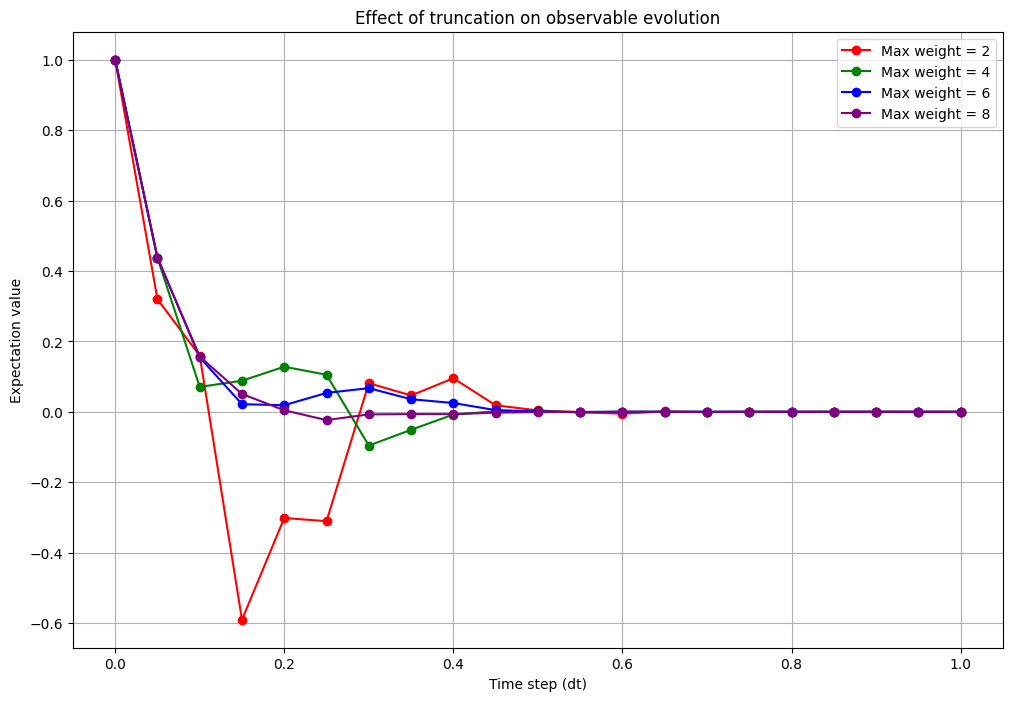

In [10]:
weight_settings = [2, 4, 6, 8]
colors = ['red', 'green', 'blue', 'purple']

plt.figure(figsize=(12, 8))

for idx, max_w in enumerate(weight_settings):
    results = []
    for dt_val in dt_values:
        parameters = jl.fill(dt_val, jl.PauliPropagation.countparameters(circuit))
        pauli_sum = jl.PauliPropagation.propagate(
            circuit, observable, parameters,
            max_weight=max_w, min_abs_coeff=min_abs_coeff
        )

        if dt_val == dt_values[0]:
            term_count = jl.length(pauli_sum)
            print(f"Max weight {max_w}: {int(term_count)} Pauli terms")

        overlap = jl.PauliPropagation.overlapwithzero(pauli_sum)
        results.append(float(overlap))

    plt.plot(dt_values, results, 'o-', color=colors[idx], label=f'Max weight = {max_w}')

plt.xlabel('Time step (dt)')
plt.ylabel('Expectation value')
plt.title('Effect of truncation on observable evolution')
plt.legend()
plt.grid(True)
plt.show()